# Introduction

In this notebook, I will extract restaurant ratings and reviews from [Foursquare](https://foursquare.com/), and use distance (one of the main ideas behind recommender systems) to generate recommendations for restaurants in one city that have similar reviews to restaurants in another city.

### Motivation

I grew up in Austin, Texas, but moved to Minneapolis, Minnesota for my wife's work.  Being people who love food, we had to find new restaurants to replace our favorites from back home.  However, most decently rated places we went to were...lacking.  They came at the recommendations of coworkers,  neighbors, or from Google ratings, but the food was often bland and overpriced.  It took us one look at the actual reviews to figure it out.  

In order to better illustrate our problem, here are recent reviews from three places we tried that we were disappointed in.  On the left is a pizza shop, the middle is a typical American restaurant, and the right is a Vietnamese restaurant:

<img style="float: left; width: 250px;" src="http://i.imgur.com/XZ00nBV.png">

<img style="float: right; width: 250px;" src="http://i.imgur.com/9C8c1ql.png">

<img style="float: none!important; display: block; width: 250px;" src="http://i.imgur.com/D15CLBU.png">

The font may be too small to read, but I highlighted the main points.  Service, atmosphere, and apparently eggrolls were the common factors.  You don't see a lot of mentions of how good the actual food is, and you can even see an instance of someone rating the pizza place as 5/5 even after saying that it is pricey.  So, obviously, there is a disconnect in how I evaluate restaurants versus how the people of Minneapolis evaluate restaurants.  If you have previously worked with recommender systems, you already know where I'm going with this.  If not, here is a primer:

### Recommender Systems Overview

Before getting into the overview of recommender systems, I wanted to point out that I won't actually be building a legitimate recommender system in this notebook.  There are some [great](https://turi.com/learn/userguide/recommender/introduction.html) [packages](https://github.com/lyst/lightfm) for doing so, but I'm going to stick with one of the main ideas behind recommender systems.  This is for two reasons:

**1)** Classes have started back up, and my available free time for side projects like this one has mostly dried up

**2)** My gastronomic adventures don't need the added benefits that a recommender system provides over what I'll be doing

If you're still interested after that, let's get back into it.

In the world of recommender systems, there are three broad types:

- **[Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)**: The most prevalent type - uses "wisdom of the crowd" for popularity among peers.  This is so popular because you don't need to know a lot about the item itself, you only need the ratings on it from people.  The two restrictions are that it has the assumption that peoples tastes do not change, and new items run into the "cold start problem".  This is when it has not yet received any ratings, and fails to appear on recommendation lists.
    - People who like item X also like item Y
    - This is how Spotify selects songs for your recommended playlist.  Specifically, it will take songs from other playlists that contain songs you recently liked.
    
    
- **[Content-Based](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)**: Recommends items based off of their similarity.  This requires reliable information about the items themselves, which makes it difficult to implement in a lot of areas.  Additionally, recommendations generated from this will likely not deviate very far from the item being compared to, but there are tricks available to account for this.  This is similar to how Pandora's model for selecting songs on a station.
    - Item X is similar to item Y
    - This is how Pandora selects songs for your stations.  Specifically, it assigns each song a list of characteristics (assigned through the [Music Genome Project](http://www.pandora.com/corporate/mgp.shtml)), and selects songs with similar characteristics as those that you liked.
    

- **[Hybrid](https://en.wikipedia.org/wiki/Recommender_system#Hybrid_recommender_systems)**: You probably guessed it - this is a combination of the above two.  The idea here is use what you have if you have it.  There are a few designs of this [worth looking into](http://www.math.uci.edu/icamp/courses/math77b/lecture_12w/pdfs/Chapter%2005%20-%20Hybrid%20recommendation%20approaches.pdf).


Those are the three main types, but there is one other type that you may find if you are reading more:


- **[Knowledge-Based](https://en.wikipedia.org/wiki/Knowledge-based_recommender_system)**: This is the most rare type due to requiring explicit domain knowledge.  This is often used for products that have a low number of available ratings, such as high luxury goods like hypercars.  We won't delve any further into this type, but I recommend reading more about them if you're interested.


### Method

Going back to our problem, the previous way of selecting restaurants at the recommendation of our coworkers and neighbors (collaborative filtering) failed, so we are going to used the idea behind content-based recommender systems.  However, we don't have a lot of content about the restaurants, so we are going to use the reviews people left for them.  More specifically, we are going to determine similarity between restaurants based off of the reviews that people write for them.  

We're going to use cosine similarity since it's generally accepted as producing better results in item-to-item filtering.  Specifically,

$\hspace{8cm}sim(A, B) = \cos(\theta) = \frac{A \cdot B}{\|A\|\|B\|}$

Before calculating this, we need to perform a couple of pre-processing steps on our reviews in order to make it more useable for our cosine similarity calculation.  These will be common NLP (**n**atural **l**anguage **p**rocessing) techniques that you should be familiar with if you have worked with text before.  There are likely better ways to go about the text processing for this problem (and please let me know if you believe there are so I can update this when I have time), but here are the steps I will be taking:

**1) Normalizing**: This just means converting our words into lower case.  This way, when we map to our feature space, we don't end up with redundant features for the same words.

    Ex. "Central Texas barbecue is the best smoked and the only barbecue that matters"

$\hspace{1.75cm}$becomes

```
    "central texas barbecue is the best smoked and the only barbecue that matters"
```

**2) Tokenizing**: This breaks up a sentence into individual words.  This is basically turning our reviews into [bags of words](https://en.wikipedia.org/wiki/Bag-of-words_model), which makes it easier to perform other operations.  Though we are going to perform many other preprocessing operations, this is more or less the beginning of mapping our comments into the feature space

    Ex. 'Central Texas barbecue is the best smoked and the only barbecue that matters'

$\hspace{1.75cm}$becomes

```
    ['Central', 'Texas', 'barbecue', 'is', 'the', 'best', 'smoked', 'and', 'the', 'only', 'barbecue', 'that', 'matters']
```

**3) Removing Stopwords and Punctuation**: Takes out unnecessary words and punctuation that we use in language that computers don't care about such as *as*, *the*, *and*, and *of*

    Ex. ['central', 'texas', 'barbecue', 'is', 'the', 'best', 'smoked', 'and', 'the', 'only', 'barbecue', 'that', 'matters']

$\hspace{1.75cm}$becomes

```
    ['central', 'texas', 'barbecue', 'best', 'smoked', 'only', 'barbecue', 'matters']
```

**4) Lemmatizing (Stemming)**: Removes variations at the end of a word to revert words to their root

    Ex. ['central', 'texas', 'barbecue', 'best', 'smoked', 'only', 'barbecue', 'matters']

$\hspace{1.75cm}$becomes

```
    ['central', 'texas', 'barbecue', 'best', 'smoke', 'only', 'barbecue', 'matter']
```

**5) Term Frequency-Inverse Document Frequency (TF-IDF)**: Determines how important a word is to a document (which is a review in this case) within a corpus (the collection documents).  This doesn't necessarily help establish context within our reviews themselves (for example, 'this Pad Kee Mao is bad ass' is technically a good thing, but it wouldn't be accounted for unless we did [n-grams](https://en.wikipedia.org/wiki/N-gram) (which will give my laptop a much more difficult time)), but it does help with establishing the importance of the word.

$\hspace{8cm}TFIDF(t, d) = TF(t, d) \cdot IDF(t)$

$\hspace{8cm}IDF(t) =  1 + \log\Big(\frac{\#\ Documents}{\#\ Documents\ Containing\ t}\Big)$

$\hspace{8cm}t:\ \text{Term}$

$\hspace{8cm}d:\ \text{Document}$

There are a lot of areas in NLP that cause difficulties that we will be ignoring due to the nature of our problem. Sarcasm, slang, misspellings, and context are common problems in NLP, but we will be ignoring these due to the limitation on time.  

### Assumptions

It's always important to state your assumptions in any analysis because a violation of them will often render the results unreliable.

- The reviews are indicative of the characteristics of the restaurant
- The language used in the reviews does not directly impact the rating
     - E.g. Reviews contain a description of their experience, but ratings are the result of the user applying weights to specific things they value
     - Ex. "The food was great, but the service was terrible." would be a 2/10 for one user, but a 7/10 for users like myself
- The restaurants did not undergo significant changes in the time frame for the reviews being pulled
- Sarcasm, slang, misspellings, and other common NLP problems will not have a significant impact on our results

---
# Restaurant Recommender


If you're still with us after all of that, let's get started!

---

In addition to the library imports, we have to specify our credentials to access the foursquare API.  I'm not keen on sharing mine (sorry, but not really), but you can get your own by [signing up](https://developer.foursquare.com/).  I stored mine in a text file which is being read in.

In [199]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.feature_extraction import text as sktext

import foursquare

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")  # Setting plotting style

%matplotlib inline

In [2]:
# Reading credentials for the API
with open('foursquareCredentials.txt') as f:
    lines = [line.split('=')[1] for line in f.readlines()]
    credentials = [line.replace("'", '').replace('\n', '') for line in lines]
    f.close()

# Assigning the credentials to an object
client = foursquare.Foursquare(
    client_id=credentials[0], 
    client_secret=credentials[1], 
    redirect_uri=credentials[2])

## The Data

Foursquare works similarly to Yelp where users will review restaurants.  They can either leave a rating (1-10), or write a comment for the restaurant.  The comment is what we're interested in here since I established above that the rating has less meaning due to the way people rate restaurants differently between the two cities.

The [documentation](https://developer.foursquare.com/docs/) was fortunately fairly robust.  I used the [foursquare categoryID tree](https://developer.foursquare.com/categorytree) in order to grab the venue category ID for the different types of restaurants.  The [venue search](https://developer.foursquare.com/docs/venues/search) function grabs the actual restaurants, and the [tips](https://developer.foursquare.com/docs/venues/tips) function returns the comments (and not what users left for a tip like you'd think).

We're going to use the individual comments, restaurant category, price tier, and the number of check-ins, comments, and users.


### Restaurants

Before pulling our restaurants, we have to first include a few parameters.  We'll begin with the cities we want to include and the restaurant types we want to include.

Since we're not interested in chains or fast food places, we have to specify which venue category IDs we want.  There are also a few grocery stores (such as Whole Foods and the magnificent [H-E-B](https://www.heb.com/)) that appear under the bakery and deli categories, so excluding this is easier than manually filtering them out.  I left them commented out so there is the full list in case anyone else would like to include them for their own uses.

In [3]:
cities = ['Austin, TX',  # Where I'm from
          'Minneapolis, MN']  # Where I'm going to grad school  

venueCategoryId = ['503288ae91d4c4b30a586d67'  # Afghan
                       , '4bf58dd8d48988d1c8941735'  # African
                       , '4bf58dd8d48988d14e941735'  # American
                       , '4bf58dd8d48988d142941735'  # Asian.  Includes most Asian countries.
                       , '4bf58dd8d48988d169941735'  # Australian
                       , '52e81612bcbc57f1066b7a01'  # Austrian
                       , '4bf58dd8d48988d1df931735'  # BBQ
                       , '4bf58dd8d48988d179941735'  # Bagel
#                        , '4bf58dd8d48988d16a941735'  # Bakery
                       , '52e81612bcbc57f1066b7a02'  # Belgian
                       , '52e81612bcbc57f1066b79f1'  # Bistro
                       , '4bf58dd8d48988d143941735'  # Breakfast
                       , '52e81612bcbc57f1066b7a0c'  # Bubble Tea
                       , '4bf58dd8d48988d16c941735'  # Burgers.  Does not include fast food.
                       , '4bf58dd8d48988d16d941735'  # Cafe
                       , '4bf58dd8d48988d17a941735'  # Cajun/Creole
                       , '4bf58dd8d48988d144941735'  # Caribbean
                       , '5293a7d53cf9994f4e043a45'  # Caucasian
                       , '4bf58dd8d48988d1e0931735'  # Coffee Shop
                       , '52e81612bcbc57f1066b7a00'  # Comfort Food
                       , '52e81612bcbc57f1066b79f2'  # Creperie
                       , '52f2ae52bcbc57f1066b8b81'  # Czech
#                        , '4bf58dd8d48988d146941735'  # Deli
                       , '4bf58dd8d48988d1d0941735'  # Dessert
                       , '4bf58dd8d48988d147941735'  # Diner
                       , '4bf58dd8d48988d148941735'  # Donuts
                       , '5744ccdfe4b0c0459246b4d0'  # Dutch
                       , '4bf58dd8d48988d109941735'  # Eastern Europe
                       , '52e81612bcbc57f1066b7a05'  # English
                       , '4bf58dd8d48988d10b941735'  # Falafel
                       , '4edd64a0c7ddd24ca188df1a'  # Fish & Chips
                       , '52e81612bcbc57f1066b7a09'  # Fondue
                       , '56aa371be4b08b9a8d57350b'  # Food Stand
                       , '4bf58dd8d48988d1cb941735'  # Food Truck
                       , '4bf58dd8d48988d10c941735'  # French
                       , '4bf58dd8d48988d155941735'  # Gastropub
                       , '4bf58dd8d48988d10d941735'  # German
                       , '4bf58dd8d48988d10e941735'  # Greek
                       , '52e81612bcbc57f1066b79ff'  # Halal
                       , '52e81612bcbc57f1066b79fe'  # Hawaiian
                       , '52e81612bcbc57f1066b79fa'  # Hungarian
                       , '4bf58dd8d48988d10f941735'  # Indian
                       , '52e81612bcbc57f1066b7a06'  # Irish Pub
                       , '4bf58dd8d48988d110941735'  # Italian
                       , '52e81612bcbc57f1066b79fd'  # Jewish
                       , '4bf58dd8d48988d112941735'  # Juice Bar
                       , '5283c7b4e4b094cb91ec88d7'  # Kebab
                       , '4bf58dd8d48988d1be941735'  # Latin American
                       , '4bf58dd8d48988d1c0941735'  # Mediterranean
                       , '4bf58dd8d48988d1c1941735'  # Mexican
                       , '4bf58dd8d48988d115941735'  # Middle Eastern
                       , '52e81612bcbc57f1066b79f9'  # Modern European
                       , '52e81612bcbc57f1066b79f8'  # Pakistani
                       , '56aa371be4b08b9a8d573508'  # Pet Cafe
                       , '4bf58dd8d48988d1ca941735'  # Pizza
                       , '52e81612bcbc57f1066b7a04'  # Polish
                       , '4def73e84765ae376e57713a'  # Portuguese
                       , '5293a7563cf9994f4e043a44'  # Russian
                       , '4bf58dd8d48988d1bd941735'  # Salad
                       , '4bf58dd8d48988d1c6941735'  # Scandinavian
                       , '5744ccdde4b0c0459246b4a3'  # Scottish
                       , '4bf58dd8d48988d1ce941735'  # Seafood
                       , '56aa371be4b08b9a8d57355a'  # Slovak
                       , '4bf58dd8d48988d1dd931735'  # Soup
                       , '4bf58dd8d48988d14f941735'  # Southern
                       , '4bf58dd8d48988d150941735'  # Spanish
                       , '5413605de4b0ae91d18581a9'  # Sri Lankan
                       , '4bf58dd8d48988d1cc941735'  # Steakhouse
                       , '4bf58dd8d48988d158941735'  # Swiss
                       , '4bf58dd8d48988d1dc931735'  # Tea Room
                       , '56aa371be4b08b9a8d573538'  # Theme Restaurant
                       , '4f04af1f2fb6e1c99f3db0bb'  # Turkish
                       , '52e928d0bcbc57f1066b7e96'  # Ukranian
                       , '4bf58dd8d48988d1d3941735'  # Vegetarian
                      ]
venueCategoryIdstr = ','.join(venueCategoryId)  # Converts to string for API call

With those specified, we'll go ahead and pull in the restaurants.  This loop will go through each restaurant category, grab the restaurants that meet our criteria, and puts them into a data frame called dfRest (**d**ata **f**rame of **rest**aurants).

Tasks like these can sometimes take a lot of time, but this fortunately runs in under a minute.

In [4]:
%%time

# Empty data frame to be filled with restaurant information
dfRest = pd.DataFrame()

for city in cities:
    
    # Run the API for each category
    for category in venueCategoryId:
        apiCall = client.venues.search(params = 
                        {'near': city
                        , 'intent': 'browse'  # Non-user based
                        , 'limit': '50'  # Max is 50
                        , 'radius': '56372'  # In meters.  Converts to 35 miles
                        , 'categoryId': category})['venues']
        if len(apiCall) == 0:
            pass
        else:
            for restaurant in np.arange(len(apiCall)):
                
                # Error handling due to not every restaurant possessing
                # a value for city/state
                try:
                    apiCity = apiCall[restaurant]['location']['city']
                    apiState = apiCall[restaurant]['location']['state']
                except:
                    apiCity = np.NaN
                    apiState = np.NaN
                
                # Appending a temporary data frame to dfRest to prevent overwriting
                temp = pd.DataFrame({
                        'name': apiCall[restaurant]['name'],
                        'id': apiCall[restaurant]['id'],
                        'category': apiCall[restaurant]['categories'][0]['name'],
                        'shortCategory': apiCall[restaurant]['categories'][0]['shortName'],
                        'city': apiCity,
                        'state': apiState,
                        'location': city,
                        'checkinsCount': apiCall[restaurant]['stats']['checkinsCount'],
                        'commentsCount': apiCall[restaurant]['stats']['tipCount'],
                        'usersCount': apiCall[restaurant]['stats']['usersCount']
                    }, index=[0])
                dfRest = pd.concat([dfRest, temp])

Wall time: 52.8 s


In [5]:
dfRest.shape

(3050, 10)

Now that we have pulled the restaurants, let's clean it up by removing any restaurants with:
- **Duplicates:** A small handful of these sneaked through, and we only need one of each
- **$<$ 10 comments:** These won't be too useful for our purposes
- **Categories we don't want:** Some of these also got through, and I have no interest in seeing how the Burger King around the corner compares to a Whataburger back home

In [6]:
# Cleaning the dataset before making more API calls
dfRest = dfRest.dropna().drop_duplicates()
dfRest = dfRest[dfRest['commentsCount'] >= 10]

# Removing unwanted categories
excludeCategories = ['Fast Food', 'Gas Station', 'Golf Course', 'Bowling Alley']
dfRest = dfRest.loc[~dfRest.category.isin(excludeCategories)]

In [10]:
dfRest.shape

(1365, 10)

While that removed more than half of our records, ~1,300 restaurants is still plenty enough to work with.  This will also drastically reduce the number of comments we need to grab, as well.

Moving on, let's look at a few charts for exploratory analysis to see what restaurants we ended up with:

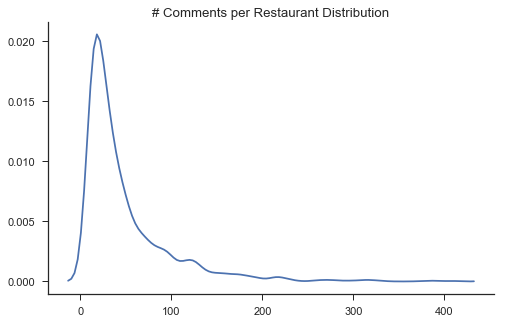

In [81]:
plt.figure(figsize=(8, 5))
sns.kdeplot(dfRest['commentsCount'], legend=False)
plt.title('# Comments per Restaurant Distribution')
sns.despine()

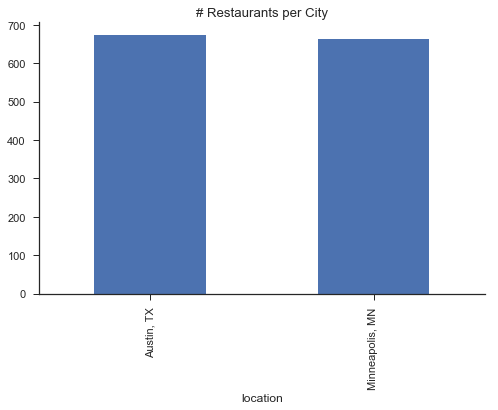

In [71]:
plt.figure(figsize=(8, 5))
dfRest['id'].groupby(dfRest['location']).count().plot(kind='bar')
plt.title('# Restaurants per City')
sns.despine()

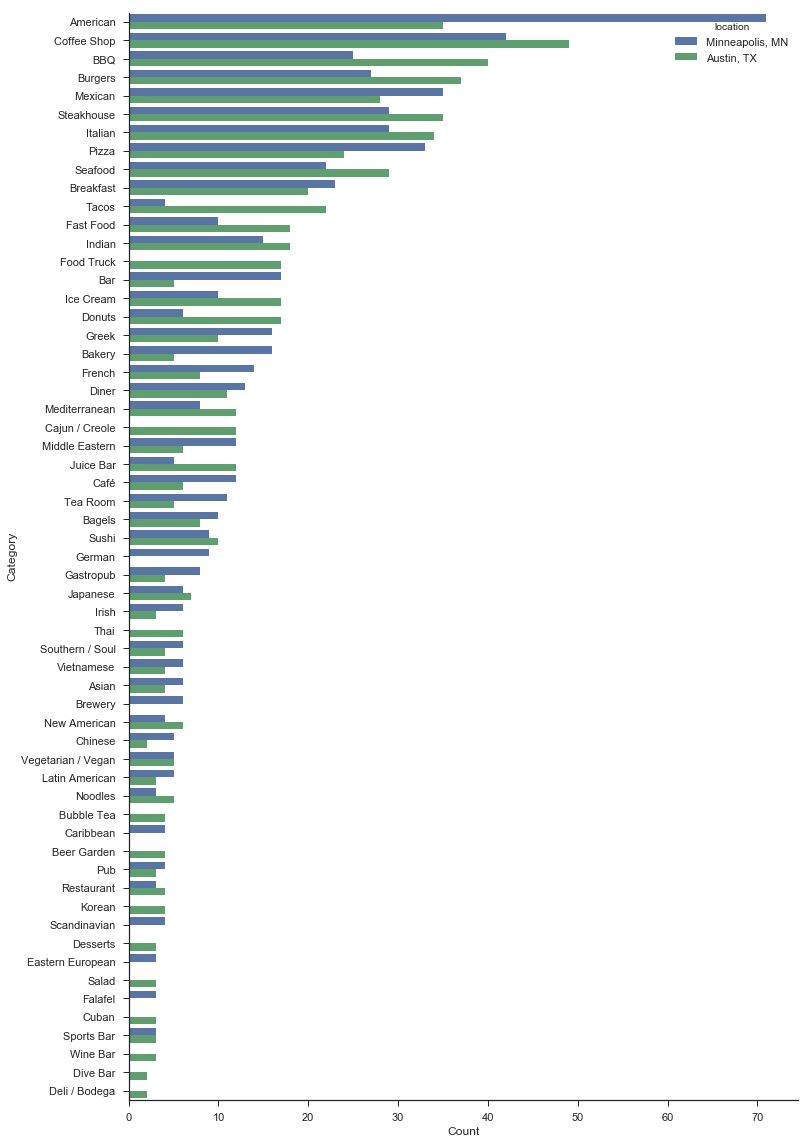

In [76]:
plt.figure(figsize=(12, 20))

# Grouping by the number of restaurants per category and city
categoryPlot = dfRest['id'].groupby(
    (dfRest['shortCategory'], dfRest['location'])).count().sort_values(
        ascending=False)[:100].reset_index()

# Plotting 
sns.barplot(x="id", y="shortCategory", hue="location", data=categoryPlot)

# Setting labels and configuring visuals
plt.xlabel('Count')
plt.ylabel('Category')
sns.despine()

So our number of restaurants between each city is basically even, most restaurants have between 10 and 70 comments, and we see a few interesting things in the breakdown between categories.  To summarize the chart:

**Austin:**
- Significantly more BBQ, tacos, food trucks, donuts, juice bars, and Cajun restaurants (but I could have told you this)
- Seemingly more diversity in the smaller categories

**Minneapolis:**
- American is king
- Significantly more bars, bakeries, middle eastern, cafes, tea rooms, German, and breweries
- More Mexican places?  That doesn't entirely sound right, but it's not a drastic difference

Our initial pull didn't include the ratings, so we'll go ahead and pull those in along with the price tier.

This loop takes a lot longer (~7 minutes), possibly due to making individual calls for each restaurant (~1,300) instead of just each category (~72).

In [29]:
%%time

ratings = []
numRatings = []
priceTiers = []

for restId in dfRest['id']:
    apiCall = client.venues(restId)['venue']
    
    try:
        rate = apiCall['rating']
        numRates = apiCall['ratingSignals']
        tiers = apiCall['attributes']['groups'][0]['items'][0]['priceTier']
    except:
        rate = np.NaN
        numRates = np.NaN
        tiers = np.NaN
        
    ratings.append(rate)
    numRatings.append(numRates)
    priceTiers.append(tiers)
    
dfRest['rating'] = ratings
dfRest['numRatings'] = numRatings
dfRest['priceTier'] = priceTiers

Wall time: 6min 17s


In [30]:
# Re-ordering the columns since the loop puts them out of order
dfRest = dfRest.reindex_axis(
    [
        'id', 'name', 'category', 'shortCategory', 'checkinsCount', 'city',
        'state', 'location', 'commentsCount', 'usersCount', 'priceTier',
        'numRatings', 'rating'
    ],
    axis=1).reset_index(drop=True)

In [31]:
# Cleaning the dataset by dropping duplicates
dfRest = dfRest.dropna().drop_duplicates()

dfRest.head()

,id,name,category,shortCategory,checkinsCount,city,state,location,commentsCount,usersCount,priceTier,numRatings,rating
0,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1769,Austin,TX,"Austin, TX",17,683,1.0,41.0,6.9
1,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1463,Austin,TX,"Austin, TX",34,1018,2.0,93.0,8.0
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1047,Pflugerville,TX,"Austin, TX",31,672,2.0,88.0,8.3
3,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,2.0,10.0,6.2
4,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,1.0,15.0,8.0


In [14]:
# Uncomment to save the results if needed
# dfRest.to_csv('dfRest.csv')

### Comments

These are the actual comments people write about the restaurants, and they are what we will be comparing for our "recommender" system.  

This loop grabs the actual comments per restaurant, and puts the comments into the data frame dfComments.  It takes ~10 minutes to run.

Since I'm using a free developer key, I'm currently limited to 30 comments per restaurant ID.  This will impact the quality for some restaurants, but we saw that most of our restaurants had under 30 comments in the earlier chart.

In [77]:
%%time

dfComments = pd.DataFrame()

for rest in dfRest['id']:
    apiCall = client.venues.tips(rest)['tips']['items']
    numComments = len(apiCall)
    
    for idx in np.arange(numComments):
        temp = pd.DataFrame({
                'id': rest,
                'comment': apiCall[idx]['text']
            }, index=[0])
        dfComments = pd.concat([dfComments, temp])
        
dfComments = dfComments.reindex_axis(['id','comment'], axis = 1).reset_index(drop=True)

Wall time: 9min 18s


In [84]:
dfComments.head()

,id,comment
0,4e17b348b0fb8567c665ddaf,"Healthy fresh salad plus baked potatoes, selec..."
1,4e17b348b0fb8567c665ddaf,Make sure to print out your coupons. These fol...
2,4e17b348b0fb8567c665ddaf,"First of all, this place uses CANNED chick pea..."
3,4e17b348b0fb8567c665ddaf,"Great healthy food, good prices. Try the ginge..."
4,4e17b348b0fb8567c665ddaf,Love coming here. Makes getting lunch so easy ...


Now we need to group the comments together so we have one set of comments per restaurant before joining everything together.

In [20]:
##### Probabily don't need this chunk -- remove it before final

# # Calculating the number of comments per restaurant and merging it to dfRest
# commentCounts = dfComments[['comment']].groupby(dfComments['id']).count().reset_index()
# commentCounts.columns = ['id', 'commentCount']

# dfRest = dfRest.merge(commentCounts, how = 'left', on = 'id')

In [86]:
# Grouping individual comments by restaurant ID
groupedComments = dfComments.groupby('id')['comment'].apply(
    lambda x: "{%s}" % ''.join(x)).reset_index()

This is where we merge everything into one data frame, df, which has a row for each restaurant that includes all of the comments.  We'll also perform an additional sanitation step here by removing non-ASCII characters from the comments.

In [342]:
# Merging everything together into one data frame
df = pd.merge(dfRest, groupedComments, on='id')

# Removing non-ASCII characters
df['comments'] = df['comment'].apply(
    lambda comment: re.sub(r'[^\x00-\x7f]', r'', comment))

df.drop('comment', axis=1, inplace=True)

df.head()

,id,name,category,shortCategory,checkinsCount,city,state,location,commentsCount,usersCount,priceTier,numRatings,rating,comments
0,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1769,Austin,TX,"Austin, TX",17,683,1.0,41.0,6.9,"{Healthy fresh salad plus baked potatoes, sele..."
1,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1463,Austin,TX,"Austin, TX",34,1018,2.0,93.0,8.0,{The lunch buffet is wonderful; everything is ...
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1047,Pflugerville,TX,"Austin, TX",31,672,2.0,88.0,8.3,"{Wonderful! Spicy lovers: Kitfo, was awesome! ..."
3,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,2.0,10.0,6.2,{Obsessed with this place. One little nugget (...
4,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,1.0,15.0,8.0,{West African fusion reigns at this darling tr...


Here's an example of the comments for one random restaurant to give a better idea of the data we're dealing with:

In [343]:
df['comments'][np.random.randint(df.shape[0])]  # Selects one restaurant at random

"{Great place for romantic evening.  Try Tortellini with Arrabbiata Moderna, a spicy cream sauce.  Delicious with the spinach salad.  Choice of full or half portions on entrees and salads.  Indulge!Anti pasta misto is a meal in and of itself. Great proscitto, cheese sortiment and greens. Good and authentic Italian style pizzasOrganic milk is available as an extra on your coffee order! Definitely worth it.Eat here! Do it often! Seriously, they're amazingly good. I adore the ravioli bolognese...Nice place and the Hot Chocolate was wonderful. Staff friendly and good vibe.Desserts are flown in from Milan - chocolate Fondant is  the best in townThe regular cups of house coffee are bottomless...sit back and enjoy!Grande coffee with tax always comes out to 2 dollars exactly.The fettucine alfredo is good too.The UNO combo platter is a great value.Awesome food and great place to meet with friends.The best chai latte & tiramisu in townI kinda prefer the gas station around the corner for a quiet 

In [344]:
# df.index = df.id
# df.drop('id', axis=1, inplace=True)

# df.to_csv('dfRestaurant.csv', sep='|')

## Data Processing

When working with language, we have to process the text into something that a computer can handle easier.  Our end result will be a large number of numerical features for each restaurant that we can calculate the cosine similarity on.

The steps here are:
1. Normalizing
2. Tokenizing
3. Removing stopwords
4. Lemmatizing (Stemming)
5. Term Frequency-Inverse Document Frequency (TF-IDF)

I'll explain a little more on what these are and why we are doing them below in case you aren't familiar with them.

### 1) Normalizing

This section uses regex scripts that makes cases every word lower cased, removes punctuation, and removes digits.

For example:

**Before:**

$\hspace{1cm}$"ThIs Is HoW mIdDlE sChOoLeRs TaLkEd 2 EaCh OtHeR oN AIM!!!!"

**After:**

$\hspace{1cm}$"this is how middle schoolers talked each other on aim"

The benefit in this is that it vastly reduces our feature space.  Our pre-processed example would have created an additional ~10 features from someone who doesn't know how to type like a regular human being.

In [345]:
# Converting all words to lower case and removing punctuation
df['comments'] = [re.sub(r'\d+\S*', '',
                  row.lower().replace('.', ' ').replace('_', '').replace('/', ''))
                  for row in df['comments']]

######### FIGURE OUT WHAT THIS DOES - THIS IS WHY YOU COMMENT YOUR CODE WHEN YOU WRITE IT#######
# 
df['comments'] = [re.sub(r'(?:^| )\w(?:$| )', '', row)
                  for row in df['comments']]

# Removing numbers
df['comments'] = [re.sub(r'\d+', '', row) for row in df['comments']]

df['comments'].head()

0    {healthy fresh salad plus baked potatoes, sele...
1    {the lunch buffet is wonderful; everything is ...
2    {wonderful! spicy lovers: kitfo, was awesome! ...
3    {obsessed with this place  one little nugget (...
4    {west african fusion reigns at this darling tr...
Name: comments, dtype: object

In [314]:
[re.sub(r'\d+', '', row) for row in df['comments']][6][0]

'{'

### 2) Tokenizing

Tokenizing a sentence is a way to map our words into a feature space.  This is achieved by treating every word as an individual object.

**Before:**

$\hspace{1cm}$'central texas barbecue is the best smoked and the only barbecue that matters'

**After:**

$\hspace{1cm}$['central', 'texas', 'barbecue', 'is', 'the', 'best', 'smoked', 'and', 'the', 'only', 'barbecue', 'that', 'matters']


In [346]:
# Tokenizing comments and putting them into a new column
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')  # by blank space
df['tokens'] = df['comments'].apply(tokenizer.tokenize)

df['tokens'].head()

0    [healthy, fresh, salad, plus, baked, potatoes,...
1    [the, lunch, buffet, is, wonderful, everything...
2    [wonderful, spicy, lovers, kitfo, was, awesome...
3    [obsessed, with, this, place, one, little, nug...
4    [west, african, fusion, reigns, at, this, darl...
Name: tokens, dtype: object

### 3) Removing Stopwords  & Punctuation

Stopwords are unnecessary words like *as*, *the*, *and*, and *of* that aren't very useful for our purposes.  Since they don't have any intrinsic value, removing them reduces our feature space which will speed up our computations.

**Before:**

$\hspace{1cm}$['central', 'texas', 'barbecue', 'is', 'the', 'best', 'smoked', 'and', 'the', 'only', 'barbecue', 'that', 'matters']

**After:**

$\hspace{1cm}$['central', 'texas', 'barbecue', 'best', 'smoked', 'only', 'barbecue', 'matters']

This does take a bit longer to run at ~6 minutes

In [347]:
%%time

filtered_words = []
for row in df['tokens']:
    filtered_words.append([
        word.lower() for word in row
        if word.lower() not in nltk.corpus.stopwords.words('english')
    ])

df['tokens'] = filtered_words

Wall time: 4min 52s


### 4) Lemmatizing (Stemming)

Stemming removes variations at the end of a word to revert words to their root in order to reduce our overall feature space (e.x. running $\rightarrow$ run).  This has the possibility to adversely impact our performance when the root word is different (e.x. university $\rightarrow$ universe), but the net positives typically outweigh the net negatives.

**Before:**

$\hspace{1cm}$['central', 'texas', 'barbecue', 'best', 'smoked', 'only', 'barbecue', 'matters']

**After:**

$\hspace{1cm}$['central', 'texas', 'barbecue', 'best', 'smoke', 'only', 'barbecue', 'matter']

One very important thing to note here is that we're actually doing something called **[Lemmatization](https://en.wikipedia.org/wiki/Lemmatisation)**, which is similar to [stemming](https://en.wikipedia.org/wiki/Stemming), but is a little different (I named this section "stemming" because it's the common nomenclature for this type of task). Both seek to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form, but they go about it in different ways.  In order to illustrate the difference, here's a dictionary entry:

<img src="http://college.cengage.com/english/raimes/keys_writers/5e/assets/students/images/annotated_dictionary_html_5c444ce8.png">

Lemmatization seeks to get the *lemma*, or the base dictionary form of the word.  In our example above, that would be "graduate".  It does this by using vocabulary and a morphological analysis of the words, rather than just chopping off the variations (the "verb forms" in the example above) like a traditional stemmer would do.

The advantage of lemmatization here is that we don't run into issues like our other example of *university* $\rightarrow$ *universe* that can happen in conventional stemmers.  It is also relatively quick on this data set!

The disadvantage is that it is not able to infer if the word is a noun/verb/adjective/etc., so we have to specify which type it is.  Since we're looking at, well, everything, we're going to lemmatize for nouns, verbs, and adjectives.

[Here](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) is an excerpt from the Stanford book *Introduction to Information Retrieval* if you wanted to read more stemming and lemmatization.

In [348]:
%%time

# Setting the Lemmatization object
lmtzr = nltk.stem.wordnet.WordNetLemmatizer()

# Looping through the words and appending the lemmatized version to a list
stemmed_nouns = []
for row in df['tokens']:
    stemmed_nouns.append([
        # Verbs
        lmtzr.lemmatize(  
            # Adjectives
            lmtzr.lemmatize(  
                # Nouns
                lmtzr.lemmatize(word.lower()), 'a'), 'v')
        for word in row
        if word.lower() not in nltk.corpus.stopwords.words('english')])

# Adding the list as a column in the data frame
df['tokens'] = stemmed_words

Wall time: 3min 2s


Let's take a look at how many unique words we now have and a few of the examples:

In [349]:
allWords = []

for row in stemmed_words:
    for word in row:
        allWords.append(str(word))
            
uniqueWords = np.unique(allWords)

print('Number of unique words:', len(uniqueWords), '\n')
print('Previewing sample of unique words:\n', uniqueWords[1234:1244])

Number of unique words: 29217 

Previewing sample of unique words:
 ['albndigas' 'alborz' 'alcachofas' 'alchemy' 'alcholic' 'alcohol'
 'alcoholic' 'alcoholthis' 'alcove' 'alcy']


We can see a few of the challenges from slang or typos that I mentioned in the beginning.  These will pose problems for what we're doing, but we'll just have to assume that the vast majority of words are spelled correctly.

Before doing the TF-IDF transformation, we need to make sure that we have spaces in between each word in the comments:

In [351]:
stemmed_sentences = []

# Spacing out the words in the reviews for each restaurant
for row in df['tokens']:
    stemmed_string = ''
    for word in row:
        stemmed_string = stemmed_string + ' ' + word
    stemmed_sentences.append(stemmed_string)
    
df['tokens'] = stemmed_sentences
stemmed_sentences[np.random.randint(len(stemmed_sentences))]

' serf high quality comfort food one austin best destination weekend brunch late night eats get chicken waffle sweet potato hash eater 38 member atx best burger list include round clock spot dont gloss upscale riff meatloaf chicken waffle save room roasted banana brown sugar milkshake everything menu look delicious come back getting exactly ordered today dark meat fried chicken waffle roasted banana brown sugar shake meal made week past midnight going wait worth burger delish roasted banana brown sugar milkshake snack get whipped potato veggie hash along w plate raw chicken really enjoyed hash ordered chicken waffle well leave eventually eat leftover like everyone find eating raw meat around clock updated diner comfort food like classic breakfast plate sweet potato hash meatloaf sandwich special made locally sourced ingredient favorite french toast chicken waffle mandatory try wait long usually prompt help waterloo record next door pas time 3 place real food ingredient waffle sandwich 

### 5) Term Frequency-Inverse Document Frequency (TF-IDF)

This determines how important a word is to a document (which is a review in this case) within a corpus (the collection documents). It is a number resulting from the following formula: 

$\hspace{8cm}TFIDF(t, d) = TF(t, d) \cdot IDF(t)$


$\hspace{8cm}IDF(t) =  1 + \log\Big(\frac{\#\ Documents}{\#\ Documents\ Containing\ t}\Big)$


$\hspace{8cm}t:\ \text{Term}$

$\hspace{8cm}d:\ \text{Document}$

Scikit-learn has an [excellent function](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) that is able to transform our processed text into a TF-IDF matrix very quickly.  We'll convert it back to a data frame, and join it to our original data frame by the indexes.

In [361]:
%%time

# Creating the sklearn object
tfidf = sktext.TfidfVectorizer(smooth_idf=False)

# Transforming our 'tokens' column into a TF-IDF matrix and then a data frame
tfidf_df = pd.DataFrame(tfidf.fit_transform(df['tokens']).toarray(), 
                        columns=tfidf.get_feature_names())

Wall time: 1.1 s


In [362]:
print(tfidf_df.shape)
tfidf_df.head()

(1338, 29188)


,00,000,007,007grab,00all,00am,00amnot,00lamb,00pm,00pmformerly,...,zucchini,zucchinithe,zuccini,zuccotto,zuchini,zuke,zuppa,zur,zushi,zzzzzzzzzzzzoops
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since we transformed *all* of the words, we have a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix).  We don't care about things like typos or words specific to one particular restaurant, so we're going to remove columns that don't have a lot of contents.

In [367]:
# Removing sparse columns
tfidf_df = tfidf_df[tfidf_df.columns[tfidf_df.sum() > 2.5]]

# Removing any remaining digits
tfidf_df = tfidf_df.filter(regex=r'^((?!\d).)*$')

print(tfidf_df.shape)
tfidf_df.head()

(1338, 1034)


,absolute,absolutely,across,actually,add,added,afternoon,ahead,ahi,al,...,wrapped,wrong,www,year,yes,yet,yogurt,york,yum,yummy
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.076958,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,0.000000,0.0,0.034089,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.023897,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.023328,0.023170
2,0.0,0.031336,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.025919,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.025131
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.064113,0.0,0.084494,0.000000,0.000000


This drastically reduced the dimensions of our data set, and we now have something usable to calculate similarity.

In [355]:
# Storing the original data frame before the merge in case any changes are needed
df_orig = df.copy()

# Renaming columns that conflict with column names in tfidfCore
df.rename(columns={'name': 'Name', 
                   'city': 'City', 
                   'location': 'Location'}, inplace=True)

# Merging the data frames by index
df = pd.merge(df, tfidf_df, how='inner', left_index=True, right_index=True)

df.head()

,id,Name,category,shortCategory,checkinsCount,City,state,Location,commentsCount,usersCount,...,wonderful,work,world,worth,would,wrap,wrong,year,yum,yummy
0,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1769,Austin,TX,"Austin, TX",17,683,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1463,Austin,TX,"Austin, TX",34,1018,...,0.077745,0.000000,0.000000,0.021425,0.0,0.000000,0.023897,0.0,0.023328,0.023170
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1047,Pflugerville,TX,"Austin, TX",31,672,...,0.028108,0.059343,0.033574,0.023238,0.0,0.000000,0.025919,0.0,0.000000,0.025131
3,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,...,0.000000,0.000000,0.000000,0.000000,0.0,0.066611,0.000000,0.0,0.000000,0.000000


Lastly, we're going to add additional features for the category.  This just puts a heavier weight on those with the same type, so for example a Mexican restaurant will be more likely to have Mexican restaurants show up as most similar instead of Brazilian restaurants.

In [356]:
# Creates dummy variables out of the restaurant category
df = pd.concat([df, pd.get_dummies(df['shortCategory'])], axis=1)

df.head()

,id,Name,category,shortCategory,checkinsCount,City,state,Location,commentsCount,usersCount,...,Tapas,Tea Room,Tex-Mex,Thai,Theme Restaurant,Turkish,Vegetarian / Vegan,Vietnamese,Wine Bar,Yogurt
0,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1769,Austin,TX,"Austin, TX",17,683,...,0,0,0,0,0,0,0,0,0,0
1,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1463,Austin,TX,"Austin, TX",34,1018,...,0,0,0,0,0,0,0,0,0,0
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1047,Pflugerville,TX,"Austin, TX",31,672,...,0,0,0,0,0,0,0,0,0,0
3,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,...,0,0,0,0,0,0,0,0,0,0
4,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,...,0,0,0,0,0,0,0,0,0,0


Because we introduced an additional type of feature, we'll have to check it's weight in comparison to the TF-IDF features:

In [386]:
# Summary stats of TF-IDF
print('Max:', np.max(tfidf_df.max()), '\n',
      'Mean:', np.mean(tfidf_df.mean()), '\n',
      'Standard Deviation:', np.std(tfidf_df.std()))

 Max: 0.887886808638 
 Mean: 0.005431524248088308 
 Standard Deviation: 0.010378140350365522


The dummy variables for the restaurant type are quite a bit higher than the average word, but I'm alright with this since I think it has a benefit.

# "Recommender System"

As a reminder, we are not using a conventional recommender system.  Instead, we are using recommender system theory by calculating the cosine distance between comments in order to find restaurants with the most similar comments.  

### Loading in personal ratings

In order to recommend restaurants with this approach, we have to identify the restaurants we want to find others that are most similar to.  I took the data frame and assigned my own ratings to some of my favorites.

In [388]:
# Loading in self-ratings for restaurants in the data set
selfRatings = pd.read_csv('selfRatings.csv', usecols=[0, 4])
selfRatings.head()

,id,selfRating
0,43c968a2f964a5209c2d1fe3,10.0
1,574481f8498e2cd16a0911a6,NaN
2,4cb5e045e262b60c46cb6ae0,9.0
3,49be75ccf964a520ad541fe3,9.0
4,4d8d295fc1b1721e798b1246,NaN


In [390]:
# Merging into df to add the column 'selfRating'
df = pd.merge(df, selfRatings)

df.head()

,id,Name,category,shortCategory,checkinsCount,City,state,Location,commentsCount,usersCount,...,Tea Room,Tex-Mex,Thai,Theme Restaurant,Turkish,Vegetarian / Vegan,Vietnamese,Wine Bar,Yogurt,selfRating
0,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1769,Austin,TX,"Austin, TX",17,683,...,0,0,0,0,0,0,0,0,0,NaN
1,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1463,Austin,TX,"Austin, TX",34,1018,...,0,0,0,0,0,0,0,0,0,NaN
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1047,Pflugerville,TX,"Austin, TX",31,672,...,0,0,0,0,0,0,0,0,0,NaN
3,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,...,0,0,0,0,0,0,0,0,0,NaN
4,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,...,0,0,0,0,0,0,0,0,0,NaN


### Additional features & min-max scaling 

We're going to include a few additional features from the original data set to capture information that the comments may not have.  Specifically:

- **Popularity:** checkinsCount, commentsCount, usersCount, numRatings
- **Price:** priceTier

We're also going to scale these down so they don't carry a huge advantage over everything else.  I'm going to scale the popularity attributes to be between 0 and 0.5, and the price attribute to be between 0 and 1.  I'll do this by first min-max scaling everything (to put it between 0 and 1), and then dividing the popularity features in half.

In [438]:
# Removing everything that won't be used in the similarity calculation
df_item = df.drop(['id', 'category', 'Name', 'shortCategory', 'City', 'tokens',
                   'comments', 'state', 'Location', 'selfRating', 'rating'],
                  axis=1)

# Copying into a separate data frame to be normalized
df_item_norm = df_item.copy()

columns_to_scale = ['checkinsCount', 'commentsCount',
                    'usersCount', 'priceTier', 'numRatings']

# Split
df_item_split = df_item[columns_to_scale]
df_item_norm.drop(columns_to_scale, axis=1, inplace=True)

# Apply
df_item_split = pd.DataFrame(MinMaxScaler().fit_transform(df_item_split),
                             columns=df_item_split.columns)
df_item_split_half = df_item_split.drop('priceTier', axis=1)
df_item_split_half = df_item_split_half / 2
df_item_split_half['priceTier'] = df_item_split['priceTier']

# Combine
df_item_norm = df_item_norm.merge(df_item_split,
                                  left_index=True, right_index=True)

df_item_norm.head()

,10,15,20,30,50,absolutely,add,almost,also,always,...,Turkish,Vegetarian / Vegan,Vietnamese,Wine Bar,Yogurt,checkinsCount,commentsCount,usersCount,priceTier,numRatings
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.031212,...,0,0,0,0,0,0.030685,0.017544,0.020431,0.000000,0.017504
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.017897,0.000000,...,0,0,0,0,0,0.024845,0.060150,0.031652,0.333333,0.046866
2,0.027891,0.0,0.0,0.0,0.0,0.031336,0.0,0.0,0.000000,0.018730,...,0,0,0,0,0,0.016907,0.052632,0.020063,0.333333,0.044043
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.037158,...,0,0,0,0,0,0.000649,0.005013,0.002244,0.333333,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0.006469,0.002506,0.012125,0.000000,0.002823


### Calculating cosine similarities

Here's the moment that we've spent all of this time getting to: the similarity.  

This section calculates the cosine similarity and puts it into a matrix with the pairwise similarity:

|      | 0    | 1    | ...  | n    |
|------|------|------|------|------|
|   0  | 1.00 | 0.03 | ...  | 0.15 |
|   1  | 0.31 | 1.00 | ...  | 0.89 |
| ...  | ...  | ...  | ...  | ...  |
| n    | 0.05 | 0.13 | ...  | 1.00 |

As a reminder, we're cosine similarity since it's generally accepted as producing better results in item-to-item filtering.  For all you math folk, here's the formula again:

$\hspace{8cm}sim(A, B) = \cos(\theta) = \frac{A \cdot B}{\|A\|\|B\|}$

In [439]:
# Calculating cosine similarity
df_item_norm_sparse = sparse.csr_matrix(df_item_norm)
similarities = cosine_similarity(df_item_norm_sparse)

# Putting into a data frame
dfCos = pd.DataFrame(similarities)

dfCos.head()

,0,1,2,3,4,5,6,7,8,9,...,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124
0,1.000000,0.056184,0.071735,0.025827,0.023465,0.061532,0.054300,0.064464,0.074760,0.072174,...,0.022121,0.050508,0.069234,0.048229,0.061761,0.029130,0.055427,0.046527,0.072510,0.050978
1,0.056184,1.000000,0.903895,0.121586,0.038370,0.167663,0.200036,0.146040,0.158681,0.153524,...,0.095853,0.130094,0.155950,0.099670,0.139589,0.116429,0.088865,0.134700,0.155253,0.135326
2,0.071735,0.903895,1.000000,0.119496,0.044507,0.145336,0.189633,0.139103,0.152732,0.153595,...,0.110362,0.124715,0.156121,0.089113,0.143617,0.105827,0.083258,0.132194,0.159888,0.142305
3,0.025827,0.121586,0.119496,1.000000,0.839805,0.082814,0.168778,0.093047,0.088544,0.109035,...,0.110280,0.077695,0.112150,0.043518,0.113468,0.099495,0.043040,0.123459,0.115808,0.109447
4,0.023465,0.038370,0.044507,0.839805,1.000000,0.033335,0.027827,0.029956,0.039069,0.032865,...,0.009019,0.023645,0.040990,0.044314,0.044694,0.010782,0.038501,0.026015,0.041859,0.023970


These are the some of the restaurants I rated very highly, and I'm pulling these up so we can use the index number in order to compare it to the others in our data set:

In [393]:
# Filtering to those from my list with the highest ratings
topRated = df[df['selfRating'] >= 8].drop_duplicates('Name')

# Preparing for display
topRated[['Name', 'category', 'Location', 'selfRating']].sort_values(
    'selfRating', ascending=False)

,Name,category,Location,selfRating
15,Jack Allen's Kitchen,American Restaurant,"Austin, TX",10.0
88,Black's Barbecue,BBQ Joint,"Austin, TX",10.0
420,Tacodeli,Taco Place,"Austin, TX",10.0
222,Round Rock Donuts,Donut Shop,"Austin, TX",10.0
28,Jack Allens on Capital of TX,American Restaurant,"Austin, TX",10.0
124,Blue Dahlia Bistro,Café,"Austin, TX",10.0
969,Chimborazo,Latin American Restaurant,"Minneapolis, MN",10.0
83,"Black's BBQ, The Original",BBQ Joint,"Austin, TX",10.0
66,The Salt Lick,BBQ Joint,"Austin, TX",10.0
636,Brasa Premium Rotisserie,BBQ Joint,"Minneapolis, MN",9.0


,cosineSimilarity,Name,City,state,Location,category,rating,selfRating
558,1.000000,The Coffee Bean & Tea Leaf,Austin,TX,"Austin, TX",Coffee Shop,8.1,8.0
791,0.867524,Caribou Coffee,Apple Valley,MN,"Minneapolis, MN",Coffee Shop,8.0,NaN
741,0.866175,Five Watt Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,8.9,NaN
746,0.848775,Dunn Bros Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,7.9,NaN
763,0.847828,Dunn Bros Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,7.1,NaN
759,0.842924,Caribou Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,8.0,NaN


In order to speed things up, we'll make a function that formats the cosine similarity data frame and retrieves the top $n$ most similar restaurants for the given restaurant:

In [457]:
def retrieve_recommendations(restaurant_index, num_recommendations=5):
    """
    Retrieves the most similar restaurants for the index of a given restaurant 
    
    Outputs a data frame showing similarity, name, location, category, and rating
    """
    # Formatting the cosine similarity data frame for merging
    similarity = pd.melt(dfCos[dfCos.index == restaurant_index])
    similarity.columns = (['restIndex', 'cosineSimilarity'])

    # Merging the cosine similarity data frame to the original data frame
    similarity = similarity.merge(
        df[['Name', 'City', 'state', 'Location',
            'category', 'rating', 'selfRating']],
        left_on=similarity['restIndex'],
        right_index=True)
    similarity.drop(['restIndex'], axis=1, inplace=True)

    # Ensuring that retrieved recommendations are for Minneapolis
    similarity = similarity[(similarity['Location'] == 'Minneapolis, MN') | (
        similarity.index == restaurant_index)]

    # Sorting by similarity
    similarity = similarity.sort_values(
        'cosineSimilarity', ascending=False)[:num_recommendations + 1]
    
    return similarity

Alright, let's test it out!

### Barbecue

Starting with the [Salt Lick](http://saltlickbbq.com/).  This is a popular central Texas barbecue place featured on [various food shows](https://www.youtube.com/watch?v=vLnsXechOWc) known for their open pit:

<img style="width: 700px;" src="http://cdn.loc.gov/service/pnp/highsm/28500/28571v.jpg">
http://localhost:8888/notebooks/Projects/Restaurant%20Recommender/Restaurant%20Recommender.ipynb
In case you're not familiar with [central Texas barbecue](https://en.wikipedia.org/wiki/Barbecue_in_Texas), it primarily features smoked meats (especially brisket) with white bread, onions, pickles, potato salad, and cornbread on the side.  Sweet tea is usually the drink of choice if you're not drinking a Shiner or Lonestar.

In [458]:
# Salt Lick
retrieve_recommendations(66)

,cosineSimilarity,Name,City,state,Location,category,rating,selfRating
66,1.000000,The Salt Lick,Driftwood,TX,"Austin, TX",BBQ Joint,9.5,10.0
636,0.733111,Brasa Premium Rotisserie,Minneapolis,MN,"Minneapolis, MN",BBQ Joint,9.3,9.0
645,0.621785,Famous Dave's,Minneapolis,MN,"Minneapolis, MN",BBQ Joint,7.4,NaN
1116,0.602565,Psycho Suzi's Motor Lounge & Tiki Garden,Minneapolis,MN,"Minneapolis, MN",Theme Restaurant,8.5,2.0
656,0.582612,Rack Shack BBQ,Burnsville,MN,"Minneapolis, MN",BBQ Joint,8.0,NaN
840,0.578782,Brit's Pub & Eating Establishment,Minneapolis,MN,"Minneapolis, MN",English Restaurant,8.8,NaN


Surprisingly, our top recommendation is one of my favorite restaurants I've found up here - Brasa!  They're actually a [creole](https://en.wikipedia.org/wiki/Louisiana_Creole_cuisine) restaurant, but they have a lot of smoked meats, corn bread, and they're probably the only restaurant I've found so far with sweet tea:

<img src="https://getbento.imgix.net/accounts/0430ef0cdee9c5699c71ec5ebdb2541c/media/images/press_thumbnail54270.jpeg?w=600&fit=max&auto=compress,format&h=600">

Funny enough, Brasa was also in [Man vs Food](https://www.youtube.com/watch?v=gZmGAi5DKE4) with Andrew Zimmerman as a guest.

Famous Dave's is an overpriced chain, and I'm really not sure why Psycho Suzi's or Brit's Pub showed up on our list.

### Donuts

Moving on, let's find some donuts.  Before maple-bacon-cereal-whatever donuts become the craze (thanks for nothing, Portland), my home town was also famous for [Round Rock Donuts](http://roundrockdonuts.com/), a simple and delicious no-nonsense donut shop.  And yes, Man vs. Food also did a segment here, too.

<img src="http://www.fronteraridge.com/wp-content/uploads/2016/10/8092563177_48b5681eb7.jpg">

In [450]:
retrieve_recommendations(222)

,cosineSimilarity,Name,City,state,Location,category,rating,selfRating
222,1.000000,Round Rock Donuts,Round Rock,TX,"Austin, TX",Donut Shop,9.4,10.0
825,0.962594,Glam Doll Donuts,Minneapolis,MN,"Minneapolis, MN",Donut Shop,9.1,2.0
670,0.873971,Granny Donuts,West Saint Paul,MN,"Minneapolis, MN",Donut Shop,7.5,NaN
827,0.866257,YoYo Donuts & Coffee Bar,Hopkins,MN,"Minneapolis, MN",Donut Shop,8.4,2.0
826,0.862637,Bogart's Doughnut Co.,Minneapolis,MN,"Minneapolis, MN",Donut Shop,7.7,NaN
830,0.847556,Mojo Monkey Donuts,Saint Paul,MN,"Minneapolis, MN",Donut Shop,8.3,1.0


Sadly, a lot of the most similar places it returned were places I've tried and didn't like.  For some reason, the donuts at most places up here are usually cold, cake-based, and covered in kitschy stuff like bacon.  However, Granny donuts looks like it could be promising, as does Bogart's:

<img style="width: 400px;" src="https://s3-media3.fl.yelpcdn.com/bphoto/VVpoCxOqusvCGpr5zAW-ZQ/o.jpg">

### Tacos

This one is probably going to be a shot in the dark, but we'll try it anyway.

[Tacodeli](http://www.tacodeli.com/) is my personal favorite taco place in Austin (yes, it's better than [Torchy's](http://torchystacos.com/)), and they're a little different than the traditional taco of a corn tortilla, meat, onions, cilantro, and lime or the chingaderas from places like Taco Bell.  They're typically on flour tortillas, and have more stuff on them:

<img style="width: 600px;" src="https://cdn.vox-cdn.com/thumbor/TiugzPrR2vKWCPitTTV1oo9a1iE=/114x0:1934x1365/1200x900/filters:focal(114x0:1934x1365)/cdn.vox-cdn.com/uploads/chorus_image/image/53151105/16112919_10154883686894449_6136333774221690944_o.0.0.jpg">

In [454]:
retrieve_recommendations(420)

,cosineSimilarity,Name,City,state,Location,category,rating,selfRating
420,1.000000,Tacodeli,Austin,TX,"Austin, TX",Taco Place,9.2,10.0
987,0.882175,Rusty Taco,Minneapolis,MN,"Minneapolis, MN",Taco Place,8.1,4.0
851,0.857016,Taco Taxi,Minneapolis,MN,"Minneapolis, MN",Taco Place,8.3,NaN
1116,0.273180,Psycho Suzi's Motor Lounge & Tiki Garden,Minneapolis,MN,"Minneapolis, MN",Theme Restaurant,8.5,2.0
579,0.262505,Hell's Kitchen,Minneapolis,MN,"Minneapolis, MN",American Restaurant,8.9,4.0
840,0.260225,Brit's Pub & Eating Establishment,Minneapolis,MN,"Minneapolis, MN",English Restaurant,8.8,NaN


It looks like there's a pretty sharp drop-off in cosine similarity after our second recommendation (which makes sense when you look at the ratio of taco places in Austin vs. Minneapolis when we pulled our data), so I'm going to discard the bottom three.  I'm surprised again that Psycho Suzi's and Brit's Pub made a second appearance, but I won't look too much into it since their cosine similarity is pretty small.

I have tried Rusty Taco, and it does seem a lot like Tacodeli.  They even sell breakfast tacos, which is a Texan thing that is very rare in the rest of the country.  The only difference is that it's just not nearly as good:

<img src="http://heavytable.com/wp-content/uploads/2011/05/rusty-taco_6-x-tacos.jpg">

Taco Taxi looks like it can be promising, but they appear to be more of a traditional taqueria.  To be fair, taqueria's have had the best tacos I've found so far up here (though most of them aren't included in this list because they were outside of the search range).

### Burritos

I'm not actually going to run our similarity function for this part because the burrito place back home actually disappeared from our data pulling query in between me originally doing this and finally having time to annotate everything to write this post.  However, I wanted to include it because it was one of my other field tests.

[Cabo Bob's](http://cabobobs.com/) is my favorite burrito place back home, and they made it to the semi-finals in the [538 best burrito in America search](https://fivethirtyeight.com/burrito/#brackets-view) losing to the overall champion.  To anyone not familiar with burrito places, they're like Chipotle, but usually better.

<img style="width: 800px;" src="http://5a41cb68e4f4b5f1172e-bf5f2072334b80bdf7b0bc4cd64c7593.r11.cf2.rackcdn.com/16c3f0f16a61fb6aeb081d8c0dd99467-b41587790ca364353f5a4b46d585058b.jpg">

[El Burrito Mercado](http://elburritomercado.com/) returned as highly similar, so we tried it.  It's tucked in the back of a mercado, and has a sit-down section and a line similar to Cabo Bob's.  We decided to go for the sit-down section since we had come from the opposite side of the metropolitan area, so the experience was a little different.  My burrito was more of a traditional Mexican burrito, but it was still pretty darn good.

<img src="https://media-cdn.tripadvisor.com/media/photo-s/06/a6/13/44/el-burrito-mercado.jpg">

### Indian

Next up is the the [Clay Pit](https://www.claypit.com/), a contemporary Indian restaurant.  They focus mostly on curry dishes with naan, though some of my friends from grad school can tell you that India has way more to offer than dishes with curry.

<img src="http://www.funjunkie.com/wp-content/themes/GeoPlaces/timthumb.php?src=http://www.funjunkie.com/wp-content/uploads/2013/06/l-23.jpg&w=600&h=345&zc=1&q=70">

In [452]:
retrieve_recommendations(338, 8)

,cosineSimilarity,Name,City,state,Location,category,rating,selfRating
338,1.000000,Clay Pit Contemporary Indian Cuisine,Austin,TX,"Austin, TX",Indian Restaurant,8.8,9.0
907,0.910971,India Palace,Saint Paul,MN,"Minneapolis, MN",Indian Restaurant,7.9,NaN
913,0.886449,India Palace,Saint Paul,MN,"Minneapolis, MN",Indian Restaurant,8.4,NaN
911,0.882978,Darbar India Grill,Minneapolis,MN,"Minneapolis, MN",Indian Restaurant,7.7,NaN
918,0.873895,Gandhi Mahal,Minneapolis,MN,"Minneapolis, MN",Indian Restaurant,8.0,NaN
920,0.871573,Best of India Indian Restaurant,Saint Louis Park,MN,"Minneapolis, MN",Indian Restaurant,7.6,NaN
915,0.863795,India House,Saint Paul,MN,"Minneapolis, MN",Indian Restaurant,7.9,NaN
908,0.859315,Dancing Ganesha,Minneapolis,MN,"Minneapolis, MN",Indian Restaurant,7.3,NaN
910,0.853384,Gorkha Palace,Minneapolis,MN,"Minneapolis, MN",Indian Restaurant,9.0,NaN


This was actually the first one I did a field test on.  When I originally looked this up, we ended up trying [Gorkha Palace](http://gorkhapalace.com/) since it was the closest one to my house with the best reviews.  It has a more expanded offering including Nepali and Tibetan food (though I wasn't complaining because I love [momos](https://en.wikipedia.org/wiki/Momo_(food)).  It was delicious, and was extremely similar to the Clay Pit.  We'll be going back.

<img style="width: 300px;" src="https://s3-media4.fl.yelpcdn.com/bphoto/gueLSLa3LY6LGjYVrGdZkw/o.jpg">

### French/Bistro

One of our favorite places back home is [Blue Dahlia Bistro](http://www.bluedahliabistro.com/), a European-style bistro specializing in French food.  They use a lot of fresh and simple ingredients, and it's a great place for a date night due to its cozy interior and decorated back patio.

<img src="https://ferociousfoodiedotcom.files.wordpress.com/2016/03/blue-dahlia21.jpg">

In [472]:
retrieve_recommendations(124)

,cosineSimilarity,Name,City,state,Location,category,rating,selfRating
124,1.000000,Blue Dahlia Bistro,Austin,TX,"Austin, TX",Café,9.1,10.0
584,0.879312,Wilde Roast Cafe,Minneapolis,MN,"Minneapolis, MN",Café,8.6,NaN
762,0.824827,Jensen's Cafe,Burnsville,MN,"Minneapolis, MN",Café,8.2,NaN
764,0.816905,Peoples Organic,Edina,MN,"Minneapolis, MN",Café,8.1,NaN
740,0.815771,Cafe Latte,Saint Paul,MN,"Minneapolis, MN",Café,9.3,NaN
683,0.812055,"Black Dog, Lowertown",Saint Paul,MN,"Minneapolis, MN",Café,8.6,NaN


I think our heavier category weighting is hurting us here since Blue Dahlia is classified as a café.  Most of the recommendations focus on American food (remember, American food is king in Minneapolis), but I'm guessing the [Wilde Roast Cafe](http://wildecafe.com/) was listed as the most similar restaurant due to the similarly cozy interior and various espresso drinks they have.  I've been there before embarking on this project, and I can tell you that the food is completely different.

<img style="width: 350px;" src="https://igx.4sqi.net/img/general/600x600/2736_Sy4oGIGsTbzfD5ykDTnPCUDgISnx9xQnDlCpqu6bGyU.jpg">


### Coffee

Speaking of coffee, let's wrap this up with coffee recommendations.  I still have a lot of places to find matches for, but since I did this project as a poor graduate student, most of them would be "that looks promising, but I haven't tried it yet".  

Sadly, a lot of my favorites from in and around Austin didn't show up since Starbucks took up most of the space when searching for coffee places (remember, we're limited to 50 results per category).  We ended up with [Mozart's](http://www.mozartscoffee.com/):

<img src="http://www.mozartscoffee.com/images/photo9_5.jpg">

and the [Coffee Bean & Tea Leaf](https://www.coffeebean.com/):

<img src="http://dining.ucr.edu/images/foodshot-coffeebean.jpg">

I ran the results for Mozart's and didn't get anything too similar back.  To be fair, there aren't any coffee shops on a river up here, and I'm sure most comments for Mozart's are about the view.  

Let's go with The Coffee Bean & Tea Leaf instead.  It's actually a small chain out of California that is overall tastier than Starbucks.

In [482]:
retrieve_recommendations(558)

,cosineSimilarity,Name,City,state,Location,category,rating,selfRating
558,1.000000,The Coffee Bean & Tea Leaf,Austin,TX,"Austin, TX",Coffee Shop,8.1,8.0
791,0.867524,Caribou Coffee,Apple Valley,MN,"Minneapolis, MN",Coffee Shop,8.0,NaN
741,0.866175,Five Watt Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,8.9,NaN
746,0.848775,Dunn Bros Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,7.9,NaN
763,0.847828,Dunn Bros Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,7.1,NaN
759,0.842924,Caribou Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,8.0,NaN


These are perfectly logical.  [Caribou](https://www.cariboucoffee.com/) is a chain popular in the Midwest (I also describe it as 'like Starbucks but better' to friends back home), and [Dunn Bros](https://dunnbrothers.com/) is similar, but specific to Minnesota.

This chart from [an article on FlowingData](http://flowingdata.com/2014/03/18/coffee-place-geography/) helps describe why I think these results make so much sense:

<img src="http://i1.wp.com/flowingdata.com/wp-content/uploads/2014/03/coffee-breakdowns-final.png?w=954">

As for my verdict, on Caribou, I actually like it better than the Coffee Bean and Tea Leaf.  I actually have a gift card for them in my wallet right now.  There also used to be a location for the Coffee Bean and Tea Leaf up here, but they closed it down shortly after I moved here (just like all of the Minnesotan [Schlotzsky's](https://www.schlotzskys.com/) locations...I'm still mad about that).

# Summary

This method ended up being like any other tool - it isn't perfect for every application, but it can work if we use it effectively.  While there is room for improvement, I am pleased with how it has been working for me so far.

I'm going to continue to use this when I'm back to having an income again, and will likely update this post in the future with either more places I try out or when I move to a new city in the future.  In the meantime, I hope you enjoyed reading, and feel free to use my code ([here is the github link](https://github.com/JeffMacaluso/Blog/blob/master/Restaurant%20Recommender.ipynb)) to try it out for your own purposes.

Happy eating!